# IndabaX Ghana AutoInland Vehicle Insurance Claim

## SETUP AND INSTRUCTIONS ON RUNNING THE NOTEBOOK
###Option 1: Running the notebook locally(In Jupyter Notebook or Any Other Means)

1.	Ensure the Train.csv, Test.csv, NigerianStateNames.csv and SampleSubmision.csv files are in the same folder as the Ghana_DataScience_Summit(Indabax).ipynb notebook.

2.	Update the path of the above mentioned files inside the notebook and then run the notebook

3.	Do ensure to have the latest version of the python packages below are installed before running the notebook
    - catboost 
    - xgboost
    - lightgbm
    - category-encoders
    - eli5 
    - seaborn
    - pandas
    - matplotlib
    - sklearn
    - numpy

###Option 2: Uploading files via Google Drive
1.	Upload the Train.csv, Test.csv and SampleSubmision.csv files into your Google drive.
2.	Update the path of the above mentioned files and then run the notebook.



## The cells below helps install the needed packages

In [ ]:
!pip install catboost

In [ ]:
!pip install category-encoders

In [ ]:
!pip install eli5

In [ ]:
!pip install sklearn

In [ ]:
!pip install numpy

In [ ]:
!pip install matplotlib

## Mounting Google drive to get access to dataset that has been uploaded to a folder in the cloud drive

In [ ]:
# Uncomment this line if you are loading data from google drive

# from google.colab import drive
# drive.mount('/content/drive')

# Importing all necessary libraries

In [ ]:
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import VotingClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, PowerTransformer
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from category_encoders import WOEEncoder
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Change the paths to the directory of the train, test, submission and state names files

In [ ]:
train_dir = '/content/drive/My Drive/Zindi/Indabax/Train.csv'
test_dir = '/content/drive/My Drive/Zindi/Indabax/Test.csv'
submission_dir = '/content/drive/My Drive/Zindi/Indabax/SampleSubmission.csv'
states_dir = '/content/drive/My Drive/Zindi/Indabax/NigerianStateNames.csv'

In [ ]:
# importing data
train = pd.read_csv(
                    train_dir, 
                    parse_dates=['Policy Start Date', 'Policy End Date', 'First Transaction Date']
                    )


test=  pd.read_csv(
                   test_dir, 
                   parse_dates=['Policy Start Date', 'Policy End Date', 'First Transaction Date']
                   )

submission = pd.read_csv(submission_dir)

nigerian_states = pd.read_csv(states_dir)

In [ ]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [ ]:
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


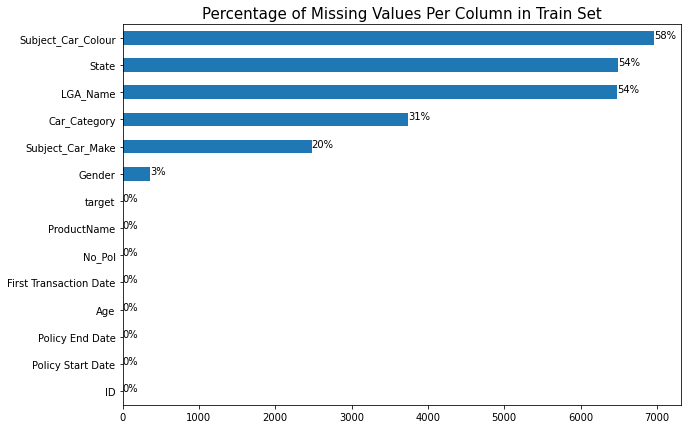

In [ ]:
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

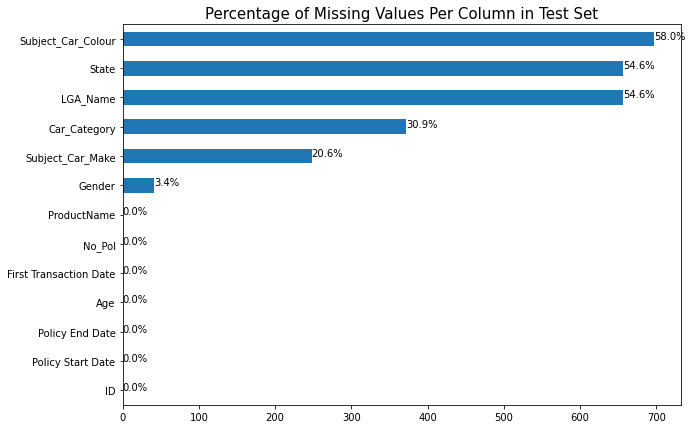

In [ ]:
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
feature_cols = ['Policy Start Date', 'Policy End Date', 'ProductName', 'Age', 'No_Pol',\
       'Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']

d = train[train.duplicated(subset=feature_cols, keep=False)].sort_values(by=feature_cols+['target'])
d.head(2)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
3389,ID_9ZVJVT3,2009-09-13,2011-09-12,Male,62,2009-09-13,2,JEEP,Black,TOYOTA,Surulere,Lagos,Car Classic,0
6917,ID_KRFLCAB,2009-09-13,2011-09-12,Male,62,2009-09-13,2,JEEP,Black,TOYOTA,Surulere,Lagos,Car Classic,1


In [ ]:
train = train.sort_values(by=feature_cols+['target']).drop_duplicates(subset=feature_cols, keep='last')
train = train.reset_index(drop=True)
train.head(2)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,NaN,NaN,Car Vintage,0
1,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0


In [ ]:
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (12095, 14)


In [ ]:
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
12090,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
12091,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
12092,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
12093,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
12094,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12095 entries, 0 to 12094
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12095 non-null  object        
 1   Policy Start Date       12095 non-null  datetime64[ns]
 2   Policy End Date         12095 non-null  datetime64[ns]
 3   Gender                  11760 non-null  object        
 4   Age                     12095 non-null  int64         
 5   First Transaction Date  12095 non-null  datetime64[ns]
 6   No_Pol                  12095 non-null  int64         
 7   Car_Category            8407 non-null   object        
 8   Subject_Car_Colour      5098 non-null   object        
 9   Subject_Car_Make        9601 non-null   object        
 10  LGA_Name                5500 non-null   object        
 11  State                   5489 non-null   object        
 12  ProductName             12095 non-null  object

In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
    if col in date_cols:
        all_data[col] = pd.to_datetime(all_data[col])

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12095 entries, 0 to 12094
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12095 non-null  object        
 1   Policy Start Date       12095 non-null  datetime64[ns]
 2   Policy End Date         12095 non-null  datetime64[ns]
 3   Gender                  11760 non-null  object        
 4   Age                     12095 non-null  int64         
 5   First Transaction Date  12095 non-null  datetime64[ns]
 6   No_Pol                  12095 non-null  int64         
 7   Car_Category            8407 non-null   object        
 8   Subject_Car_Colour      5098 non-null   object        
 9   Subject_Car_Make        9601 non-null   object        
 10  LGA_Name                5500 non-null   object        
 11  State                   5489 non-null   object        
 12  ProductName             12095 non-null  object

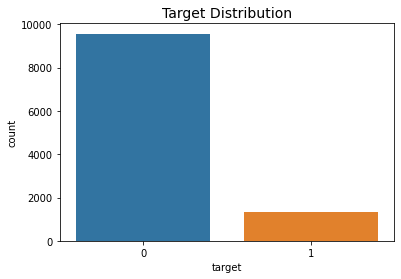

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

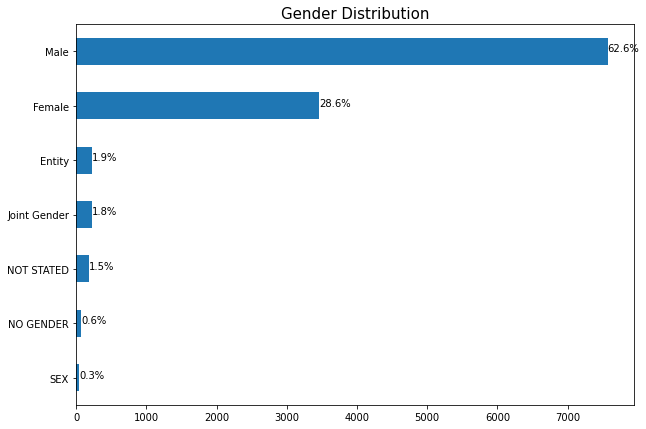

In [ ]:
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      7570
Female    3457
Other      733
Name: Gender, dtype: int64

In [ ]:
subject_car_colour_rename = {
    "Dark Grey": "Dark Gray",
    "D. Red": "Dark Red",
    "Gray & Gray": "Gray",
    "D. Gold": "Dark Gold",
    "Blue & Red": "Red & Blue",
    "Yellow & White": "White & Yellow",
    "White & Red": "Red & White",
}

subject_car_make_rename = {
    ".": np.nan,
    "Land Rover.": "Land Rover",
    "Wrangler Jeep": "Jeep"
}

states = {
    "N-A": np.nan,
}


all_data.State = all_data.State.replace(states)
all_data.Subject_Car_Colour = all_data.Subject_Car_Colour.replace(subject_car_colour_rename)
all_data.Subject_Car_Make = all_data.Subject_Car_Make.replace(subject_car_make_rename)


In [ ]:
for col in cat_cols:
    all_data[col] = np.where(all_data[col]=='As Attached', np.nan, all_data[col])
    all_data[col] = np.where(all_data[col]=='Other', np.nan, all_data[col])

In [ ]:
for col in cat_cols:
    print(col)
    print(all_data[col].unique(), '\n')

In [ ]:
for col in all_data.columns:
    if col not in ['ID', 'target']:
        all_data[col+"_imputed"] =   np.where(all_data[col].isna(),1,0)
        if col in date_cols+cat_cols:
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
        elif col in num_cols:
            all_data[col] = all_data[col].fillna(all_data[col].mean())

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                               0
Age_imputed                       0
Car_Category                      0
Car_Category_imputed              0
First Transaction Date            0
First Transaction Date_imputed    0
Gender                            0
Gender_imputed                    0
ID                                0
LGA_Name                          0
LGA_Name_imputed                  0
No_Pol                            0
No_Pol_imputed                    0
Policy End Date                   0
Policy End Date_imputed           0
Policy Start Date                 0
Policy Start Date_imputed         0
ProductName                       0
ProductName_imputed               0
State                             0
State_imputed                     0
Subject_Car_Colour                0
Subject_Car_Colour_imputed        0
Subject_Car_Make                  0
Subject_Car_Make_imputed          0
dtype: int64

In [ ]:

for col in ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']:
    all_data.loc[:, col] = all_data[col].apply(lambda x: x.lstrip())
    all_data.loc[:, col] = all_data[col].apply(lambda x: x.rstrip())
    
for col in ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']:
    all_data.loc[:, col] = all_data[col].apply(lambda x: str(x).lower())
    all_data.loc[:, col] = all_data[col].apply(lambda x: str(x).lower())
    
state_name = {
 'aba-north': 'abia-state',
 'aba-south': 'abia-state',
 'abia': 'abia-state',
 'aboh-mbaise': 'imo-state',
 'abuja': 'capital-fct',
 'abuja-municipal': 'abuja-municipal-area-council',
 'abule-egba': 'alimosho',
 'ado-ekiti': 'ekiti-state',
 'ado-ota': 'ogun-state',
 'ajao-estate': 'oshodi-isolo',
 'ajegunle-state': 'lagos-state',
 'akoko-west': 'ondo-state',
 'akwa-ibom': 'state-akwa-ibom',
 'anambra': 'anambra-state',
 'anambra-east': 'anambra-state',
 'aniocha-south': 'delta-state',
 'asari-toru': 'rivers-state',
 'awka-north': 'anambra-state',
 'awka-south': 'anambra-state',
 'bauchi': 'bauchi-state',
 'bayelsa': 'bayelsa-state',
 'benue': 'benue-state',
 'calabar-municipality': 'cross-river-state',
 'central-abuja': 'capital-fct',
 'cross-river': 'cross-river-state',
 'delta': 'delta-state',
 'ebonyi': 'ebonyi-state',
 'edo': 'edo-state',
 'ekiti-east': 'ekiti-state',
 'ekiti-west': 'ekiti-state',
 'enugu-north': 'enugu-state',
 'enugu-south': 'enugu-state',
 'esan-central': 'edo-state',
 'esan-west': 'edo-state',
 'essien-udim': 'akwa-ibom-state',
 'ethiope-east': 'delta-state',
 'etsako-west': 'edo-state',
 'gombe': 'gombe-state',
 'ibadan-east': 'oyo-state',
 'ibadan-north': 'oyo-state',
 'ibadan-west': 'oyo-state',
 'ibarapa-central': 'oyo-state',
 'idemili-north': 'anambra-state',
 'ifako-ijaye': 'ifako-ijaiye',
 'ife-north': 'osun-state',
 'ijebu-east': 'ogun-state',
 'ijebu-north': 'ogun-state',
 'ijebu-ode': 'ogun-state',
 'ile-oluji': 'ile-oluji-okeigbo',
 'ilesha-east': 'osun-state',
 'ilesha-west': 'osun-state',
 'ilorin-east': 'kwara-state',
 'ilorin-west': 'kwara-state',
 'imo': 'imo-state',
 'isoko-north': 'delta-state',
 'isoko-south': 'delta-state',
 'jos-north': 'plateau-state',
 'jos-south': 'plateau-state',
 'kaduna': 'kaduna-state',
 'kaduna-north': 'kaduna-state',
 'kaduna-south': 'kaduna-state',
 'kano': 'kano-state',
 'kano-municipal': 'kano-state',
 'kebbi': 'kebbi-state',
 'kogi': 'kogi-state',
 'kwara': 'kwara-state',
 'lagelu-north': 'oyo-state',
 'lagos': 'lagos-state',
 'nasarawa': 'nasarawa-state',
 'ndokwa-east': 'delta-state',
 'nnewi-south': 'anambra-state',
 'nsit-ubium': 'akwa-ibom-state',
 'obia-akpor': 'rivers-state',
 'ogba-ndoni': 'rivers-state',
 'ogbmosho-south': 'oyo-state',
 'ogun': 'ogun-state',
 'ogun-waterside': 'ogun-state',
 'ondo': 'ondo-state',
 'ondo-west': 'ondo-state',
 'onitsha-north': 'anambra-state',
 'orile-iganmu': 'surulere',
 'osun': 'osun-state',
 'other': 'other',
 'ovia-southwest': 'edo-state',
 'owerri-municipal': 'imo-state',
 'owerri-north': 'imo-state',
 'owerri-west': 'imo-state',
 'oyo': 'oyo-state',
 'oyo-east': 'oyo-state',
 'oyo-west': 'oyo-state',
 'port-harcourt': 'rivers-state',
 'quaan-pan': 'qua-an-pan',
 'rivers': 'rivers-state',
 'udi-agwu': 'udi',
 'ughelli-north': 'delta-state',
 'umuahia-south': 'abia-state',
 'warri-central': 'delta-state',
 'warri-north': 'delta-state'}

lga_name = {
 'ado-odo/ota': 'ado',
 'ajegunle,lagos--state': 'ajeromi-ifelodun',
 'bekwara': 'bekwarra',
 'calabar-municipality': 'calabar',
 'central-area,-abuja': 'abuja',
 'ibeju/lekki': 'ibeju',
 'ifako-ijaye': 'ifako-ijaiye',
 'ikeja-g.r.a': 'ikeja',
 'ilesha-east': 'ilesha',
 'ilesha-west': 'ilesha',
 'obia/akpor': 'obio-akpor',
 'ogba': 'ogba-egbema-ndoni',
 'ogba/egbema/ndoni': 'ogba-egbema-ndoni',
 'ogbmosho-south': 'ogbomoso',
 'ogudu': 'obudu',
 'okpe,-delta-state': 'okpe',
 'olamabolo': 'olamaboro',
 'ovia-southwest': 'ovia-south-west',
 'somolu': 'shomolu'}

all_data.State = all_data.State.replace(state_name)
all_data.LGA_Name = all_data.State.replace(lga_name)

all_data.replace(' ', '-', regex=True, inplace=True)
    

In [ ]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target', 'Policy Start Date_imputed',
       'Policy End Date_imputed', 'Gender_imputed', 'Age_imputed',
       'First Transaction Date_imputed', 'No_Pol_imputed',
       'Car_Category_imputed', 'Subject_Car_Colour_imputed',
       'Subject_Car_Make_imputed', 'LGA_Name_imputed', 'State_imputed',
       'ProductName_imputed'],
      dtype='object')

In [ ]:
agg_cols = [x for x in all_data.columns if x not in ['ID', 'target']]
aggs =[np.mean, np.max, pd.Series.skew, pd.Series.kurtosis, np.std, np.median]
new_agg = list()
for col in agg_cols:
    if '_imputed' not in col:
        temp1 = all_data.groupby(col)['No_Pol'].agg(aggs)
        temp2 = all_data.groupby(col)['Age'].agg(aggs)
        
        for agg in temp1.keys():
            all_data[f'{col}_No_Pol_{agg}'] = all_data[col].map(temp1.to_dict()[agg])
            new_agg.append(f'{col}_No_Pol_{agg}')
        
        for agg in temp2.keys():
            all_data[f'{col}_Age_{agg}'] = all_data[col].map(temp2.to_dict()[agg])
            new_agg.append(f'{col}_Age_{agg}')

In [ ]:
for col in new_agg:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

In [ ]:
def age_bins(x):
    if x < 18:
        return 'young'
    elif x >= 18 and x <36:
        return 'young Adult'
    elif x >=36 and x < 56:
        return 'Adult'
    elif x >= 56:
        return 'senior'
    
def car_category_bins(x):
    

    load = [ 'truck', 'tipper-truck', 'pick-up->-3-tons', 'shape-of-vehicle-chasis']
    passenger = ['saloon', 'jeep', 'bus', 'mini-bus','motorcycle', 'sedan', 'wagon', 'camry-car-hire', 'van', 'mini-van']
    both = ['station-4-wheel', 'pick-up']
    
    if x in load:
        return 'load'
    elif x in passenger:
        return 'passenger'
    elif x in both:
        return 'both'
    
def car_size(x):
    
    small = ['motorcycle', 'shape-of-vehicle-chasis']
    medium = ['saloon', 'sedan', 'camry-car-hire']
    large = ['truck', 'pick-up', 'van', 'mini-bus', 'wagon', 'mini-van', 'jeep']
    extra_large = ['pick-up->-3-tons', 'tipper-truck', 'station-4-wheel', 'bus']
    
    if x in small:
        return 'small'
    if x in medium:
        return 'medium'
    if x in large:
        return 'large'
    if x in extra_large:
        return 'extra_large'

all_data['age_bins'] = all_data['Age'].apply(age_bins)
all_data['car_size'] = all_data['Car_Category'].apply(car_size)
all_data['car_category_bins'] = all_data['Car_Category'].apply(car_category_bins)

feature_bins = ['car_category_bins', 'car_size', 'age_bins']

In [ ]:
for col in date_cols:
    if col not in ['First Transaction Date']:
        all_data.loc[:, 'weekend'+'_'+col] = (all_data[col].dt.weekday >=5).astype(int)
        all_data.loc[:, 'weeknum'+'_'+col] = all_data[col].dt.strftime('%W').astype(int)
        for date_feature in ['year', 'month', 'day', 'quarter', 'weekday']:
            all_data[col+"_"+date_feature] = getattr(all_data[col].dt, date_feature)
            
all_data.loc[:,'policy_duration_weeks']=round((all_data['Policy End Date']\
                                                 -all_data['Policy Start Date'])/np.timedelta64(1, 'W'))
all_data.loc[:,'policy_duration_months']=round((all_data['Policy End Date']\
                                                  -all_data['Policy Start Date'])/np.timedelta64(1, 'M'))
all_data.loc[:,'policy_duration_days']=round((all_data['Policy End Date']\
                                                -all_data['Policy Start Date'])/np.timedelta64(1, 'D'))
all_data.loc[:,'policy_duration_years']=round((all_data['Policy End Date']\
                                                -all_data['Policy Start Date'])/np.timedelta64(1, 'Y'))

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date_imputed,Policy End Date_imputed,Gender_imputed,Age_imputed,First Transaction Date_imputed,No_Pol_imputed,Car_Category_imputed,Subject_Car_Colour_imputed,Subject_Car_Make_imputed,LGA_Name_imputed,State_imputed,ProductName_imputed,Policy Start Date_No_Pol_mean,Policy Start Date_No_Pol_amax,Policy Start Date_No_Pol_skew,Policy Start Date_No_Pol_kurt,Policy Start Date_No_Pol_std,Policy Start Date_No_Pol_median,Policy Start Date_Age_mean,Policy Start Date_Age_amax,Policy Start Date_Age_skew,Policy Start Date_Age_kurt,Policy Start Date_Age_std,Policy Start Date_Age_median,Policy End Date_No_Pol_mean,Policy End Date_No_Pol_amax,...,State_No_Pol_median,State_Age_mean,State_Age_amax,State_Age_skew,State_Age_kurt,State_Age_std,State_Age_median,ProductName_No_Pol_mean,ProductName_No_Pol_amax,ProductName_No_Pol_skew,ProductName_No_Pol_kurt,ProductName_No_Pol_std,ProductName_No_Pol_median,ProductName_Age_mean,ProductName_Age_amax,ProductName_Age_skew,ProductName_Age_kurt,ProductName_Age_std,ProductName_Age_median,age_bins,car_size,car_category_bins,weekend_Policy Start Date,weeknum_Policy Start Date,Policy Start Date_year,Policy Start Date_month,Policy Start Date_day,Policy Start Date_quarter,Policy Start Date_weekday,weekend_Policy End Date,weeknum_Policy End Date,Policy End Date_year,Policy End Date_month,Policy End Date_day,Policy End Date_quarter,Policy End Date_weekday,policy_duration_weeks,policy_duration_months,policy_duration_days,policy_duration_years
0,ID_O51ZQ1B,2001-12-11,2011-12-10,female,37,2001-12-11,1,saloon,black,honda,lagos-state,lagos-state,Car-Vintage,0.0,0,0,0,0,0,0,0,0,0,1,1,0,1.0,1,2.379726,6.133076,0.594197,1.0,37.0,37,0.704563,4.374735,27.121407,37.0,1.102564,2,...,1.0,41.525645,320,-53.620474,2993.552796,108.114744,40.0,2.000000,3,0.000000,2.000000,0.707107,2,46.000000,65,1.593884,2.349408,11.401754,41,Adult,medium,passenger,0,50,2001,12,11,4,1,1,49,2011,12,10,4,5,522.0,120.0,3651.0,10.0
1,ID_VJ1FAVO,2002-03-25,2011-03-24,male,37,2002-03-25,1,saloon,black,toyota,benue-state,benue-state,Car-Classic,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1,2.379726,6.133076,0.594197,1.0,37.0,37,0.704563,4.374735,27.121407,37.0,1.314286,3,...,1.0,44.016420,320,5.897961,83.070678,18.406049,41.0,1.302666,6,2.598875,8.451096,0.641213,1,43.370781,320,-72.056402,5602.108322,77.055819,40,Adult,medium,passenger,0,12,2002,3,25,1,0,0,12,2011,3,24,1,3,469.0,108.0,3286.0,9.0
2,ID_ULWS8VL,2003-04-13,2011-04-12,male,41,2003-04-13,2,saloon,black,toyota,lagos-state,lagos-state,Car-Vintage,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2,2.379726,6.133076,0.594197,2.0,41.0,41,0.704563,4.374735,27.121407,41.0,1.200000,2,...,1.0,41.525645,320,-53.620474,2993.552796,108.114744,40.0,2.000000,3,0.000000,2.000000,0.707107,2,46.000000,65,1.593884,2.349408,11.401754,41,Adult,medium,passenger,1,14,2003,4,13,2,6,0,15,2011,4,12,2,1,417.0,96.0,2921.0,8.0
3,ID_ZYKGSP7,2003-12-21,2034-05-20,male,48,2003-12-21,2,saloon,black,bmw,lagos-state,lagos-state,Car-Vintage,0.0,0,0,0,0,0,0,0,1,0,1,1,0,2.0,2,2.379726,6.133076,0.594197,2.0,48.0,48,0.704563,4.374735,27.121407,48.0,2.000000,2,...,1.0,41.525645,320,-53.620474,2993.552796,108.114744,40.0,2.000000,3,0.000000,2.000000,0.707107,2,46.000000,65,1.593884,2.349408,11.401754,41,Adult,medium,passenger,1,50,2003,12,21,4,6,1,20,2034,5,20,2,5,1587.0,365.0,11108.0,30.0
4,ID_OEWBKGF,2005-08-05,2011-09-29,female,44,2005-08-05,1,saloon,black,tata,lagos-state,lagos-state,CVTP,0.0,0,0,0,0,0,0,1,1,0,0,0,0,1.0,1,2.379726,6.133076,0.594197,1.0,44.0,44,0.704563,4.374735,27.121407,44.0,1.588235,4,...,1.0,41.525645,320,-53.620474,2993.552796,108.114744,40.0,1.766900,10,3.255721,13.622071,1.426297,1,51.752914,320,1.185809,4.227182,40.178975,42,Adult,medium,passenger,0,31,2005,8,5,3,4,0,39,2011,9,29,3,3,321.0,74.0,2246.0,6.0


In [ ]:
for col in all_data.columns:
    if col not in ['First Transaction Date']+date_cols+num_cols+['ID', 'target']+cat_cols:
        if '_month' in col:
            all_data[f'{col}_sin'] = np.sin((all_data[col] - 1) * (2. * np.pi / 12.))
            all_data[f'{col}_cos'] = np.cos((all_data[col] - 1) * (2. * np.pi / 12.))
        elif '_day' in col:
            all_data[f'{col}_sin'] = np.sin((all_data[col] - 1) * (2. * np.pi / 31.))
            all_data[f'{col}_cos'] = np.cos((all_data[col] - 1) * (2. * np.pi / 31.))

In [ ]:
all_data.Age.unique()

array([   37,    41,    48,    44,    45,    39,    31,    62,    50,
          20,   120,    27,    32,    33,    70,    47,    36,    53,
          51,    93,    15,    34,    35,    40,    42,    61,    64,
          66,    30,     1,    25,    57,    82,    38,    65,    43,
          54,    60,     6,    28,    46,    52,    24,    29,    49,
          69,    81,    67,    55,    85,    56,    63,    78,    80,
          23,    26,    58,    68,     3,     4,    71,    76,    12,
       -5939,    59,     5,    75,    73,    77,    89,   320,     2,
          21,    79,    72,     7,    84,    18,    10,     9,    83,
         100,    11,     8,    74,   -26,    22,    -2,   133,    86,
          19,   112,    13,   -27,   -12,   -76,    90,    14,   128,
         -22,     0,   144,   -51, -6099,    16,   102,   140,    17,
          87,    88])

In [ ]:
all_data.Age = all_data.Age.abs()
all_data['log_age'] = np.log10(all_data['Age'] + 1)
age = {
    5939: 59,
    6099: 60,
    320: 32
}
all_data.Age = all_data.Age.replace(age)
all_data.Age.unique()

array([ 37,  41,  48,  44,  45,  39,  31,  62,  50,  20, 120,  27,  32,
        33,  70,  47,  36,  53,  51,  93,  15,  34,  35,  40,  42,  61,
        64,  66,  30,   1,  25,  57,  82,  38,  65,  43,  54,  60,   6,
        28,  46,  52,  24,  29,  49,  69,  81,  67,  55,  85,  56,  63,
        78,  80,  23,  26,  58,  68,   3,   4,  71,  76,  12,  59,   5,
        75,  73,  77,  89,   2,  21,  79,  72,   7,  84,  18,  10,   9,
        83, 100,  11,   8,  74,  22, 133,  86,  19, 112,  13,  90,  14,
       128,   0, 144,  16, 102, 140,  17,  87,  88])

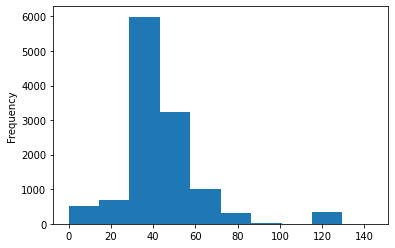

In [ ]:
all_data.Age.plot(kind='hist');

In [ ]:
q25, q75 = np.percentile(all_data['Age'], 25), np.percentile(all_data['Age'], 75)
print(f'Quartile 25: {q25} | Quartile 75: {q75}')

f_iqr = q75 - q25
print(f'iqr: {f_iqr}')

f_cut_off = f_iqr * 1.5
f_lower, f_upper = q25 - f_cut_off, q75 + f_cut_off
print(f'Cut Off: {f_cut_off}')
print(f'Age Lower: {f_lower}')
print(f'Age Upper: {f_upper}')

outliers = [x for x in all_data.Age.values if x < f_lower or x > f_upper]
print(f'Feature Age Outliers: {len(outliers)}')
print(f'Age outliers:{outliers}')

median_upper = all_data.loc[all_data['Age'] > f_upper, 'Age'].median()
median_lower = all_data.loc[all_data['Age'] < f_lower, 'Age'].median()
print(f'median_lower: {median_lower}')
print(f'median_upper: {median_upper}')



Quartile 25: 35.0 | Quartile 75: 50.0
iqr: 15.0
Cut Off: 22.5
Age Lower: 12.5
Age Upper: 72.5
Feature Age Outliers: 1128
Age outliers:[120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 93, 93, 93, 93, 120, 1, 1, 82, 6, 1, 120, 120, 81, 81, 120, 120, 1, 120, 85, 120, 78, 80, 80, 1, 120, 120, 1, 120, 120, 120, 120, 3, 120, 120, 120, 4, 6, 76, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 12, 1, 5, 1, 1, 120, 120, 1, 75, 12, 12, 6, 73, 77, 77, 120, 89, 2, 79, 7, 7, 120, 1, 1, 2, 2, 82, 1, 1, 120, 1, 2, 7, 77, 1, 1, 2, 12, 120, 3, 2, 80, 84, 84, 120, 120, 120, 120, 10, 73, 75, 79, 10, 1, 3, 9, 3, 89, 1, 1, 83, 83, 1, 1, 1, 1, 83, 120, 100, 76, 120, 120, 120, 1, 78, 12, 12, 12, 12, 12, 12, 120, 1, 2, 6, 11, 11, 76, 76, 81, 73, 1, 8, 74, 120, 120, 5, 7, 11, 1, 1, 3, 120, 120, 120, 120, 120, 1, 1, 120, 1, 1, 10, 10, 10, 10, 120, 76, 76, 76, 10, 10, 3, 78, 120, 80, 120, 120, 78, 81, 76, 7, 5, 5, 5, 5, 84, 1, 3, 1, 2, 84, 12, 12, 12, 12, 12, 12, 12, 12, 80, 75, 1, 6, 120, 1, 1

In [ ]:
cat_cols

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [ ]:
c = cat_cols + num_cols
combn2 = list(itertools.combinations(c, 2))
combn_cols2 = list()
for c1, c2 in combn2:
    combn_cols2.append(c1 + "_" + c2)
    all_data.loc[:, c1 + "_" + c2] = all_data[c1].astype(str) + "_" + all_data[c2].astype(str)
    
combn_num = list(itertools.combinations(['Age', 'No_Pol'], 2))
for c1, c2 in combn_num:
    all_data.loc[:, c1 + "_add_" + c2] = all_data[c1].astype('int32') + all_data[c2].astype('int32')
    all_data.loc[:, c1 + "_mul_" + c2] = all_data[c1].astype('int32') * all_data[c2].astype('int32')
    all_data.loc[:, c1 + "_sub_" + c2] = all_data[c1].astype('int32') - all_data[c2].astype('int32')
    all_data.loc[:, c2 + "_sub_" + c1] = all_data[c2].astype('int32') - all_data[c1].astype('int32')

In [ ]:
combn3 = list(itertools.combinations(c, 3))
combn_cols3 = list()
for c1, c2, c3 in combn3:
    combn_cols3.append(c1 + "_" + c2 + "_" + c3)
    all_data.loc[:, c1 + "_" + c2 + "_" + c3] = all_data[c1].astype(str) + "_" + all_data[c2].astype(str) + "_" + all_data[c3].astype(str)

In [ ]:
cat_cols = cat_cols + feature_bins + combn_cols2 + combn_cols3

In [ ]:
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date_imputed,Policy End Date_imputed,Gender_imputed,Age_imputed,First Transaction Date_imputed,No_Pol_imputed,Car_Category_imputed,Subject_Car_Colour_imputed,Subject_Car_Make_imputed,LGA_Name_imputed,State_imputed,ProductName_imputed,Policy Start Date_No_Pol_mean,Policy Start Date_No_Pol_amax,Policy Start Date_No_Pol_skew,Policy Start Date_No_Pol_kurt,Policy Start Date_No_Pol_std,Policy Start Date_No_Pol_median,Policy Start Date_Age_mean,Policy Start Date_Age_amax,Policy Start Date_Age_skew,Policy Start Date_Age_kurt,Policy Start Date_Age_std,Policy Start Date_Age_median,Policy End Date_No_Pol_mean,Policy End Date_No_Pol_amax,...,Car_Category_State_Age,Car_Category_State_No_Pol,Car_Category_ProductName_Age,Car_Category_ProductName_No_Pol,Car_Category_Age_No_Pol,Subject_Car_Colour_Subject_Car_Make_LGA_Name,Subject_Car_Colour_Subject_Car_Make_State,Subject_Car_Colour_Subject_Car_Make_ProductName,Subject_Car_Colour_Subject_Car_Make_Age,Subject_Car_Colour_Subject_Car_Make_No_Pol,Subject_Car_Colour_LGA_Name_State,Subject_Car_Colour_LGA_Name_ProductName,Subject_Car_Colour_LGA_Name_Age,Subject_Car_Colour_LGA_Name_No_Pol,Subject_Car_Colour_State_ProductName,Subject_Car_Colour_State_Age,Subject_Car_Colour_State_No_Pol,Subject_Car_Colour_ProductName_Age,Subject_Car_Colour_ProductName_No_Pol,Subject_Car_Colour_Age_No_Pol,Subject_Car_Make_LGA_Name_State,Subject_Car_Make_LGA_Name_ProductName,Subject_Car_Make_LGA_Name_Age,Subject_Car_Make_LGA_Name_No_Pol,Subject_Car_Make_State_ProductName,Subject_Car_Make_State_Age,Subject_Car_Make_State_No_Pol,Subject_Car_Make_ProductName_Age,Subject_Car_Make_ProductName_No_Pol,Subject_Car_Make_Age_No_Pol,LGA_Name_State_ProductName,LGA_Name_State_Age,LGA_Name_State_No_Pol,LGA_Name_ProductName_Age,LGA_Name_ProductName_No_Pol,LGA_Name_Age_No_Pol,State_ProductName_Age,State_ProductName_No_Pol,State_Age_No_Pol,ProductName_Age_No_Pol
0,ID_O51ZQ1B,2001-12-11,2011-12-10,female,37,2001-12-11,1,saloon,black,honda,lagos-state,lagos-state,Car-Vintage,0.0,0,0,0,0,0,0,0,0,0,1,1,0,1.0,1,2.379726,6.133076,0.594197,1.0,37.0,37,0.704563,4.374735,27.121407,37.0,1.102564,2,...,saloon_lagos-state_37,saloon_lagos-state_1,saloon_Car-Vintage_37,saloon_Car-Vintage_1,saloon_37_1,black_honda_lagos-state,black_honda_lagos-state,black_honda_Car-Vintage,black_honda_37,black_honda_1,black_lagos-state_lagos-state,black_lagos-state_Car-Vintage,black_lagos-state_37,black_lagos-state_1,black_lagos-state_Car-Vintage,black_lagos-state_37,black_lagos-state_1,black_Car-Vintage_37,black_Car-Vintage_1,black_37_1,honda_lagos-state_lagos-state,honda_lagos-state_Car-Vintage,honda_lagos-state_37,honda_lagos-state_1,honda_lagos-state_Car-Vintage,honda_lagos-state_37,honda_lagos-state_1,honda_Car-Vintage_37,honda_Car-Vintage_1,honda_37_1,lagos-state_lagos-state_Car-Vintage,lagos-state_lagos-state_37,lagos-state_lagos-state_1,lagos-state_Car-Vintage_37,lagos-state_Car-Vintage_1,lagos-state_37_1,lagos-state_Car-Vintage_37,lagos-state_Car-Vintage_1,lagos-state_37_1,Car-Vintage_37_1
1,ID_VJ1FAVO,2002-03-25,2011-03-24,male,37,2002-03-25,1,saloon,black,toyota,benue-state,benue-state,Car-Classic,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1,2.379726,6.133076,0.594197,1.0,37.0,37,0.704563,4.374735,27.121407,37.0,1.314286,3,...,saloon_benue-state_37,saloon_benue-state_1,saloon_Car-Classic_37,saloon_Car-Classic_1,saloon_37_1,black_toyota_benue-state,black_toyota_benue-state,black_toyota_Car-Classic,black_toyota_37,black_toyota_1,black_benue-state_benue-state,black_benue-state_Car-Classic,black_benue-state_37,black_benue-state_1,black_benue-state_Car-Classic,black_benue-state_37,black_benue-state_1,black_Car-Classic_37,black_Car-Classic_1,black_37_1,toyota_benue-state_benue-state,toyota_benue-state_Car-Classic,toyota_benue-state_37,toyota_benue-state_1,toyota_benue-state_Car-Classic,toyota_benue-state_

In [ ]:
for col in cat_cols:
    frequencies = all_data[col].value_counts(normalize=True)
    mapping = all_data[col].map(frequencies)
    all_data[col + "_israre"] = np.where(mapping < 0.01, 1, 0)

In [ ]:
%%time
ss = [x for x in all_data.columns if x not in ['ID', 'target']+date_cols]

all_data['sum'] = all_data[ss].sum(axis=1)  
all_data['min'] = all_data[ss].min(axis=1)
all_data['max'] = all_data[ss].max(axis=1)
all_data['mean'] = all_data[ss].mean(axis=1)
all_data['std'] = all_data[ss].std(axis=1)
all_data['skew'] = all_data[ss].skew(axis=1)
all_data['kurt'] = all_data[ss].kurtosis(axis=1)
all_data['med'] = all_data[ss].median(axis=1)
all_data['range'] = all_data['max'] - all_data['min']

CPU times: user 5.68 s, sys: 192 ms, total: 5.87 s
Wall time: 5.85 s


In [ ]:
def get_counts(col, df):
  counts = df[col].value_counts().to_dict()
  df[col+'_counts'] = all_data[col].map(counts)

In [ ]:
get_counts('Gender', all_data)
get_counts('ProductName', all_data)
get_counts('State', all_data)
get_counts('Subject_Car_Make', all_data)
get_counts('LGA_Name', all_data)

In [ ]:
all_data['age_by_no_pol_mean'] = all_data.groupby(['No_Pol'])['Age'].transform(lambda x:x.mean())
all_data['age_by_state_mean'] = all_data.groupby(['State'])['Age'].transform(lambda x:x.mean())

In [ ]:
all_data['age_by_car_cat_mean'] = all_data.groupby(['Car_Category'])['Age'].transform(lambda x:x.mean())

In [ ]:
all_data['polisy_end_weekofyear'] = all_data['Policy End Date'].dt.weekofyear
all_data['polisy_end_weekofyear_sin'] = np.sin(2* np.pi * all_data['polisy_end_weekofyear'])

In [ ]:
all_data['polisy_start_weekofyear'] = all_data['First Transaction Date'].dt.weekofyear
all_data['polisy_start_weekofyear_sin'] = np.sin(2* np.pi * all_data['polisy_start_weekofyear'])

In [ ]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target']).tolist()

In [ ]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((10893, 479), (1202, 479))

In [ ]:
te = WOEEncoder(cols=cat_cols, random_state=14)
train_df = te.fit_transform(train_df, train_df.target, random_state = 14)
test_df = te.transform(test_df)

In [ ]:
scaler = StandardScaler()
power = PowerTransformer()
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
train_df[main_cols] = pipeline.fit_transform(train_df[main_cols])
test_df[main_cols] = pipeline.transform(test_df[main_cols])

In [ ]:
corr_matrix = train_df[main_cols].corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print('There are {} correlated columns to remove.'.format(len(to_drop)))
print(to_drop)

There are 175 correlated columns to remove.
['Age_Age_mean', 'Age_Age_median', 'Age_add_No_Pol', 'Age_sub_No_Pol', 'Car_Category_Age_kurt', 'Car_Category_Age_median', 'Car_Category_Age_skew', 'Car_Category_Age_std', 'Car_Category_LGA_Name_State', 'Car_Category_LGA_Name_israre', 'Car_Category_No_Pol_amax', 'Car_Category_No_Pol_kurt', 'Car_Category_No_Pol_skew', 'Car_Category_ProductName_No_Pol', 'Car_Category_State', 'Car_Category_State_Age', 'Car_Category_State_Age_israre', 'Car_Category_State_No_Pol', 'Car_Category_State_No_Pol_israre', 'Car_Category_State_ProductName', 'Car_Category_State_ProductName_israre', 'Car_Category_State_israre', 'Car_Category_Subject_Car_Colour_State', 'Car_Category_Subject_Car_Colour_State_israre', 'Car_Category_Subject_Car_Make_State', 'Car_Category_Subject_Car_Make_State_israre', 'Car_Category_israre', 'Gender_Age_kurt', 'Gender_Age_mean', 'Gender_Age_median', 'Gender_Age_skew', 'Gender_Age_std', 'Gender_Car_Category_ProductName', 'Gender_Car_Category_Sta

In [ ]:

main_cols = list(set(main_cols).difference(to_drop))

In [ ]:
train_df.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Date_imputed,Policy End Date_imputed,Gender_imputed,Age_imputed,First Transaction Date_imputed,No_Pol_imputed,Car_Category_imputed,Subject_Car_Colour_imputed,Subject_Car_Make_imputed,LGA_Name_imputed,State_imputed,ProductName_imputed,Policy Start Date_No_Pol_mean,Policy Start Date_No_Pol_amax,Policy Start Date_No_Pol_skew,Policy Start Date_No_Pol_kurt,Policy Start Date_No_Pol_std,Policy Start Date_No_Pol_median,Policy Start Date_Age_mean,Policy Start Date_Age_amax,Policy Start Date_Age_skew,Policy Start Date_Age_kurt,Policy Start Date_Age_std,Policy Start Date_Age_median,Policy End Date_No_Pol_mean,Policy End Date_No_Pol_amax,...,Subject_Car_Make_LGA_Name_ProductName_israre,Subject_Car_Make_LGA_Name_Age_israre,Subject_Car_Make_LGA_Name_No_Pol_israre,Subject_Car_Make_State_ProductName_israre,Subject_Car_Make_State_Age_israre,Subject_Car_Make_State_No_Pol_israre,Subject_Car_Make_ProductName_Age_israre,Subject_Car_Make_ProductName_No_Pol_israre,Subject_Car_Make_Age_No_Pol_israre,LGA_Name_State_ProductName_israre,LGA_Name_State_Age_israre,LGA_Name_State_No_Pol_israre,LGA_Name_ProductName_Age_israre,LGA_Name_ProductName_No_Pol_israre,LGA_Name_Age_No_Pol_israre,State_ProductName_Age_israre,State_ProductName_No_Pol_israre,State_Age_No_Pol_israre,ProductName_Age_No_Pol_israre,sum,min,max,mean,std,skew,kurt,med,range,Gender_counts,ProductName_counts,State_counts,Subject_Car_Make_counts,LGA_Name_counts,age_by_no_pol_mean,age_by_state_mean,age_by_car_cat_mean,polisy_end_weekofyear,polisy_end_weekofyear_sin,polisy_start_weekofyear,polisy_start_weekofyear_sin
0,ID_O51ZQ1B,2001-12-11,2011-12-10,-1.583734,-0.262514,2001-12-11,-0.502710,-0.493768,-0.535218,-0.594212,-0.164794,-0.164794,0.391056,0.0,0.0,0.0,-0.310349,0.0,0.0,0.0,-0.661544,-1.269983,-0.515647,0.913317,0.911290,0.0,-2.864338,-3.087703,0.094144,0.363376,0.239588,-0.124017,-0.703096,-2.976160,-0.056599,0.45481,1.194756,-1.316384,-1.321968,-1.374045,...,1.384365,0.737571,-0.649521,1.384365,0.737571,-0.649521,0.557805,1.540275,0.733126,2.645335,-0.755765,-0.407461,0.769164,1.943613,-1.010985,0.769164,1.943613,-1.010985,0.782982,-0.500907,-0.188634,0.420655,-0.500907,-0.817011,0.470759,0.877330,0.736925,0.396165,-1.583734,-1.687603,0.492731,-1.184209,0.492731,-0.312826,-0.182858,-0.366847,1.535542,-2.116807,1.547600,0.895523
1,ID_VJ1FAVO,2002-03-25,2011-03-24,0.631419,-0.262514,2002-03-25,-0.502710,-0.493768,-0.535218,0.185142,1.799129,1.799129,0.623529,0.0,0.0,0.0,-0.310349,0.0,0.0,0.0,-0.661544,-1.269983,-0.515647,-1.094911,-1.097346,0.0,-2.864338,-3.087703,0.094144,0.363376,0.239588,-0.124017,-0.703096,-2.976160,-0.056599,0.45481,1.194756,-1.316384,0.514653,-0.018315,...,-0.722353,0.737571,-0.649521,-0.722353,0.737571,-0.649521,-1.792743,-0.649235,-1.364022,-0.378024,1.323162,-0.407461,0.769164,-0.514506,0.989135,0.769164,-0.514506,0.989135,-1.277169,0.991369,-0.188634,0.420655,0.991369,1.213827,-0.610196,-0.802591,-1.004978,0.396165,0.631419,0.898693,-2.025745,0.793979,-2.025745,-0.312826,0.183516,-0.366847,-0.752406,0.174872,-0.854169,1.175514
2,ID_ULWS8VL,2003-04-13,2011-04-12,0.631419,-0.013412,2003-04-13,1.964363,-0.493768,-0.535218,0.185142,-0.164794,-0.164794,0.391056,0.0,0.0,0.0,-0.310349,0.0,0.0,0.0,-0.661544,-1.269983,-0.515647,-1.094911,-1.097346,0.0,2.250431,-1.393376,0.094144,0.363376,0.239588,8.063385,-0.327454,-2.692710,-0.056599,0.45481,1.194756,0.029624,-0.307123,-1.374045,...,1.384365,-1.355801,-0.649521,1.384365,-1.355801,-0.649521,0.557805,1.540275,0.733126,2.645335,-0.755765,-0.407461,0.769164,1.943613,0.989135,0.769164,1.943613,0.989135,0.782982,-0.564241,0.760970,-1.460455,-0.564241,-1.178912,-0.669121,-0.276492,0.736925,-1.297090,0.631419,-1.687603,0.492731,0.793979,0.492731,1.312762,-0.182858,-0.366847,-0.526855,-0.596521,-0.720236,-0.529011
3,ID_ZYKGSP7,2003-12-21,2034-05-20,0.631419

In [ ]:
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

weight = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = dict(enumerate(weight))


# Train model
model1 = CatBoostClassifier(
                            iterations= 1000,
                            l2_leaf_reg= 9,
                            verbose=0,
                            learning_rate = 0.09861049893576007,
                            subsample = 0.7461947894521731,
                            class_weights=dict(weight),
                            )


model2= LGBMClassifier(
                          boosting_type = 'dart',
                          learning_rate= 0.013841870561135103,
                          max_depth= 50,
                          n_estimators= 750,
                          num_leaves= 75,
                          subsample= 0.647439178606144,
                          class_weight=dict(weight),
                       )

model3=XGBClassifier(
                          max_depth= 50,
                          n_estimators= 750,
                          num_leaves= 75,
                          subsample= 0.647439178606144,
                          class_weight=dict(weight)
                    )



model = VotingClassifier(estimators=[('catb', model1),('lgbm',model2), ('xgb', model3)], voting='hard')

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))

F1 score on the X_test is: 0.6029411764705882
[[900  57]
 [ 51  82]]


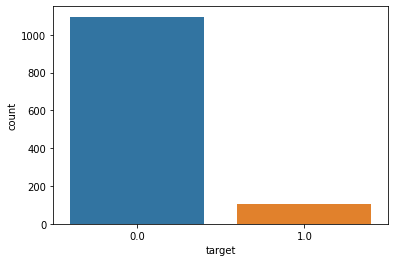

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = submission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('submission_test.csv', index = False)